In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import random
from scipy.stats import multivariate_normal

In [112]:
from struct import unpack
import numpy as np
import matplotlib.pylab as plt 

def loadmnist(imagefile, labelfile):

    # Open the images with gzip in read binary mode
    images = open(imagefile, 'rb')
    labels = open(labelfile, 'rb')

    # Get metadata for images
    images.read(4)  # skip the magic_number
    number_of_images = images.read(4)
    number_of_images = unpack('>I', number_of_images)[0]
    rows = images.read(4)
    rows = unpack('>I', rows)[0]
    cols = images.read(4)
    cols = unpack('>I', cols)[0]

    # Get metadata for labels
    labels.read(4)
    N = labels.read(4)
    N = unpack('>I', N)[0]

    # Get data
    x = np.zeros((N, rows*cols), dtype=np.uint8)  # Initialize numpy array
    y = np.zeros(N, dtype=np.uint8)  # Initialize numpy array
    for i in range(N):
        for j in range(rows*cols):
            tmp_pixel = images.read(1)  # Just a single byte
            tmp_pixel = unpack('>B', tmp_pixel)[0]
            x[i][j] = tmp_pixel
        tmp_label = labels.read(1)
        y[i] = unpack('>B', tmp_label)[0]

    images.close()
    labels.close()
    return (x, y)

def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    #plt.show()

####Loading MNIST dataset

In [4]:
#Get file paths
path = r'/home/sadat/Documents/DSE/Data/HW3_210/'
train_img_path = path + 'train-images.idx3-ubyte'
train_lbl_path = path + 'train-labels.idx1-ubyte'
test_img_path  = path + 't10k-images.idx3-ubyte'
test_lbl_path  = path + 't10k-labels.idx1-ubyte'

In [5]:
#loading data
train_img, train_lbl = loadmnist(train_img_path, train_lbl_path)
test_img, test_lbl = loadmnist(test_img_path, test_lbl_path)

####Break training dataset into sample and validation

In [6]:
#Define variables
n_samples = len(train_img)
x = train_img
y = train_lbl

#Create random indices
sample_index=random.sample(range(len(x)),int(len(x)/6))
valid_index=[i for i in range(len(x)) if i not in sample_index]

#Sample and validation images
sample_images=[x[i] for i in sample_index]
valid_images=[x[i] for i in valid_index]

#Sample and validation targets
sample_target=[y[i] for i in sample_index]
valid_target=[y[i] for i in valid_index]

In [76]:
def classify(sample_target, sample_images, valid_target, valid_images, smooth):

    #Empty list for probabilities
    prob = []
    
    #Calculate probability for each digit
    for label in range(10):    
        #Collect indices for given digit
        indices = [i for i,x in enumerate(sample_target) if x == label]
        #Calculate Pi
        pi = len(indices)/len(sample_target)
        #Calculate Multivariate Normal
        images = [sample_images[i] for i in indices]
        mean = np.mean(images, axis = 0)
        cov = np.cov(np.transpose(images)) + (smooth*np.identity(784)) #Cov with smoothing
        func = multivariate_normal(mean, cov)
        #Calculate probability and append
        prob.append(np.log(pi) + func.logpdf(valid_images))
    
    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)
    
    #Compare with valid target to get error
    error = np.sum([i!=j for i,j in zip(max_prob, valid_target)])/len(valid_target)
    return error

####Optimize Smooting 

In [ ]:
#First we looked at 1000-7000 in steps of 1000. 4000 was the optimum.
#Then we looked at 3500-4500 in steps of 500. 3500 was the optimum.
#Then we looked at 3400-3600 in steps of 100. 2500 was the optimum.
#Then we looked at 3400-3500 in steps of 50. 3450 was the optimum.
#Then we looked at 3430-3470 in steps of 10. 3460 was the optimum.
#Then we looked at 3455-3465 in steps of 5. 3460 was the optimum.
#Then we looked at 3458-3463 in steps of 1. 3461 was the optimum.


y = []
x = []
for i in range(3460, 3463, 1):
    y.append(sample_target, sample_images, valid_target, valid_images, classify(i))
    x.append(i)

Best Smooting:	 3461
Error Rate:	 4.982 %


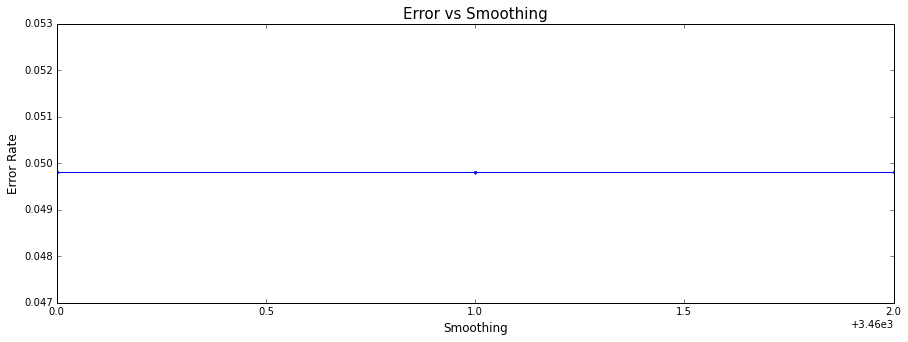

In [74]:
plt.figure(figsize=(15,5))
plt.plot(x,y, '.-')
plt.xlabel('Smoothing', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.title('Error vs Smoothing', fontsize=15)

print('Best Smooting:\t',x[1])
print('Error Rate:\t',y[1]*100,'%')

####Test dataset

In [80]:
error = classify(train_lbl, train_img, test_lbl, test_img, 3461)

In [81]:
print('Error Rate:\t',error*100,'%')

Error Rate:	 4.35 %


####Error Analysis

In [142]:
def find_error(sample_target, sample_images, valid_target, valid_images, smooth):

    #Empty list for probabilities
    prob = []
    
    #Calculate probability for each digit
    for label in range(10):    
        #Collect indices for given digit
        indices = [i for i,x in enumerate(sample_target) if x == label]
        #Calculate Pi
        pi = len(indices)/len(sample_target)
        #Calculate Multivariate Normal
        images = [sample_images[i] for i in indices]
        mean = np.mean(images, axis = 0)
        cov = np.cov(np.transpose(images)) + (smooth*np.identity(784)) #Cov with smoothing
        func = multivariate_normal(mean, cov)
        #Calculate probability and append
        prob.append(np.log(pi) + func.logpdf(valid_images))
    
    #Take the max pdf
    max_prob = np.argmax(prob, axis = 0)
    
    #Compare with valid target to get error
    label = []
    image = []
    probability = []
    prob = np.matrix(prob)
    for index in range(len(valid_target)):
        if valid_target[index] != max_prob[index]:
            image.append(valid_images[index])
            label.append(max_prob[index])
            probability.append(prob[:, index])
    return [image, label, probability]

In [144]:
#Getting data
[image, label, probability] = find_error(train_lbl, train_img, test_lbl, test_img, 3461)

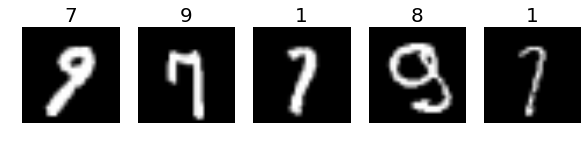

In [183]:
#Display misclassified images with predicted labels
index = 0
plt.figure(figsize=(10,5))
for img, lbl in zip(image[:5], label[:5]):
    index += 1
    plt.subplot(1, 5, index)
    displaychar(img)
    plt.title('%i' % lbl, fontsize = 20)

In [187]:
#Print Pr(y|x)
df = pd.DataFrame(probability[0])
for i in range(1,5):
    df[i] = probability[i]
df.columns = label[:5]
df

,7,9,1,8,1
0,-4186.661557,-4203.668298,-4160.350450,-4230.114178,-4113.099312
1,-4153.727277,-4247.534598,-4033.122464,-4480.068631,-4028.860527
2,-4135.793805,-4188.670598,-4093.842354,-4189.058036,-4096.008630
3,-4134.124041,-4150.912405,-4106.824477,-4186.711625,-4087.091568
4,-4128.269855,-4100.252960,-4081.650086,-4201.329781,-4065.779144
5,-4165.195886,-4142.821984,-4138.146288,-4187.380141,-4101.503712
6,-4248.912901,-4252.904287,-4171.074083,-4334.419605,-4116.236918
7,-4066.306752,-4064.252587,-4042.312542,-4270.549219,-4039.110788
8,-4095.070285,-4139.658802,-4074.009865,-4159.490337,-4077.885273
9,-4072.156086,-4063.184009,-4065.422586,-4180.498521,-4041.416520


Based on the <b>P(y|x)</b>, we can see that while our predicted label had the max probability, the correct label has the second or third highest probability.